In [47]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV

In [48]:
df=pd.read_excel("premiums.xlsx")
print(df.shape)
df.head(3)

(50000, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [49]:
df.columns=df.columns.str.replace(' ','_').str.lower()
#to replace all the spaces with the under score and to lower case
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [50]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

the data has very less no.of null rows as comppaared to the numner of rows available, so lets just drop them

In [51]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

df.duplicated().sum()
#if data present duplicate values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

no duplicate values present in our data 

In [52]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


WE have to work on number_of_dependants because it cant be negative,age because age cannot be 356, income because 930 lakhs may be a outlier 

In [53]:
#number_of_dependants	 cannot be negative , but we can see negative values in the data set ,
#so lets look into them
print(df[df.number_of_dependants<0].shape)
df[df.number_of_dependants<0]["number_of_dependants"].unique()

(72, 13)


array([-3, -1])

In [54]:
#we have to duscuss with the that we should remove those 72 rows or make them positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

now the df["number_of_dependants"] feature is fine

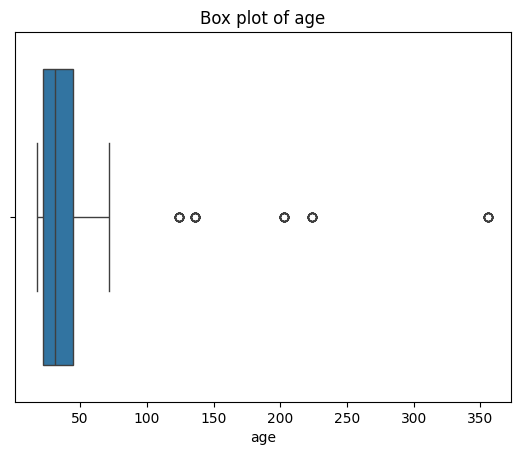

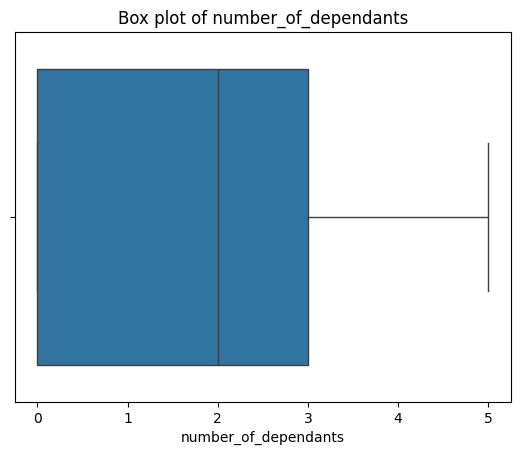

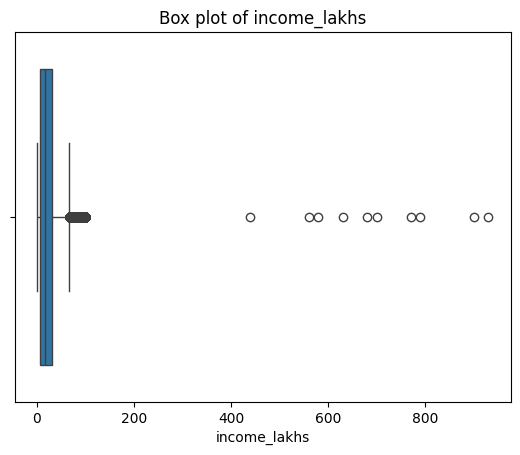

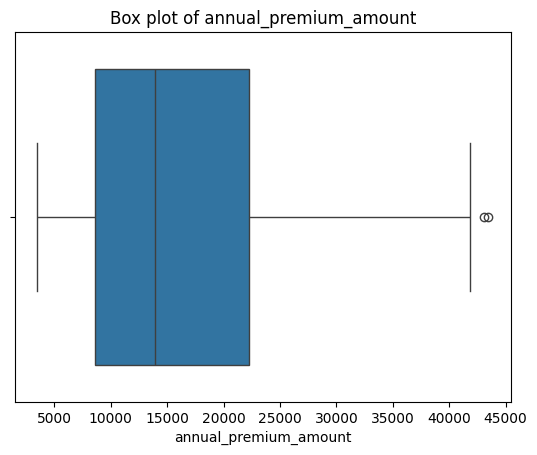

In [55]:
#lets work on outliers , plot box plot for each numeric column
numeric_columns=df.select_dtypes(["float64","int64"]).columns
for numeric_column in numeric_columns:
    sns.boxplot(x=df[numeric_column])
    plt.title(f'Box plot of {numeric_column}')
    plt.show()

##### age and income features have noticible outliers , which we have to deal with ; annual premium also as an outlier but normally a man can have greater annual plan , so it doesnt matter

In [56]:
# for age no need of using any stastical methods to handle outliers , simply can trim upto 100;
df[df.age>100].shape

(58, 13)

In [57]:
#58 rows have inoppropriate age , lets drop them and copy data into a new df , the orignaal df doesnt effected
df1=df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


#max age is 72 , it looks appropriate 

<Axes: xlabel='income_lakhs', ylabel='Count'>

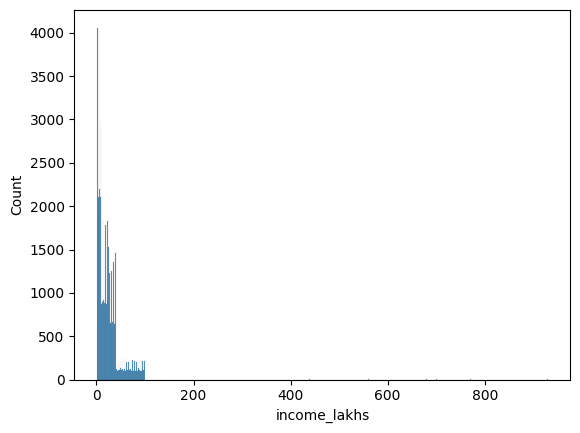

In [58]:
#now we have to work with income feature
sns.histplot(x=df1.income_lakhs)

In [59]:
def get_iqR_bounds(col):
    q1,q3=col.quantile([0.25,0.75])
    IQR=q3-q1
    lower_bound=q1-1.5*IQR
    upper_bound=q3+1.5*IQR
    return lower_bound,upper_bound
    

In [60]:
lower_bound,upper_bound=get_iqR_bounds(df1.income_lakhs)
lower_bound,upper_bound

(-29.0, 67.0)

we dont have to worry about lower bound because anyway our minimum value in income_lakhs feature is 1 and also 67 doesnt looks like a appropriate upper bound because , 67 lakhs in india is not that much , and so many people have more thean that , we have to discuss with the client , in this case lets use different method

In [61]:
quantile_treshold=df1.income_lakhs.quantile(0.999)
quantile_treshold

np.float64(100.0)

this looks goood , 1 crore income level is a decent level ,lets see how many aare lies more than that

In [62]:
df1[df1.income_lakhs>quantile_treshold].shape

(10, 13)

only 10 people have income more than our threshold , 100 in this case, lets drop them and store in new data frame df2

In [63]:
df2=df1[df1.income_lakhs<quantile_treshold]
df2[df2.income_lakhs>quantile_treshold].shape

(0, 13)

our new df has 0 been rows which have income more than our thrwshold

In [64]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49808.000000,49808.000000,49808.000000,49808.000000
mean,34.399333,1.717214,22.735083,15756.332276
std,13.683206,1.492056,21.921788,8417.581174
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8602.000000
50%,31.000000,2.000000,16.000000,13919.000000
75%,45.000000,3.000000,31.000000,22263.250000
max,72.000000,5.000000,99.000000,43471.000000


now we get rid of outliers , lets plot an histogram to get an understanding on the distribution of data

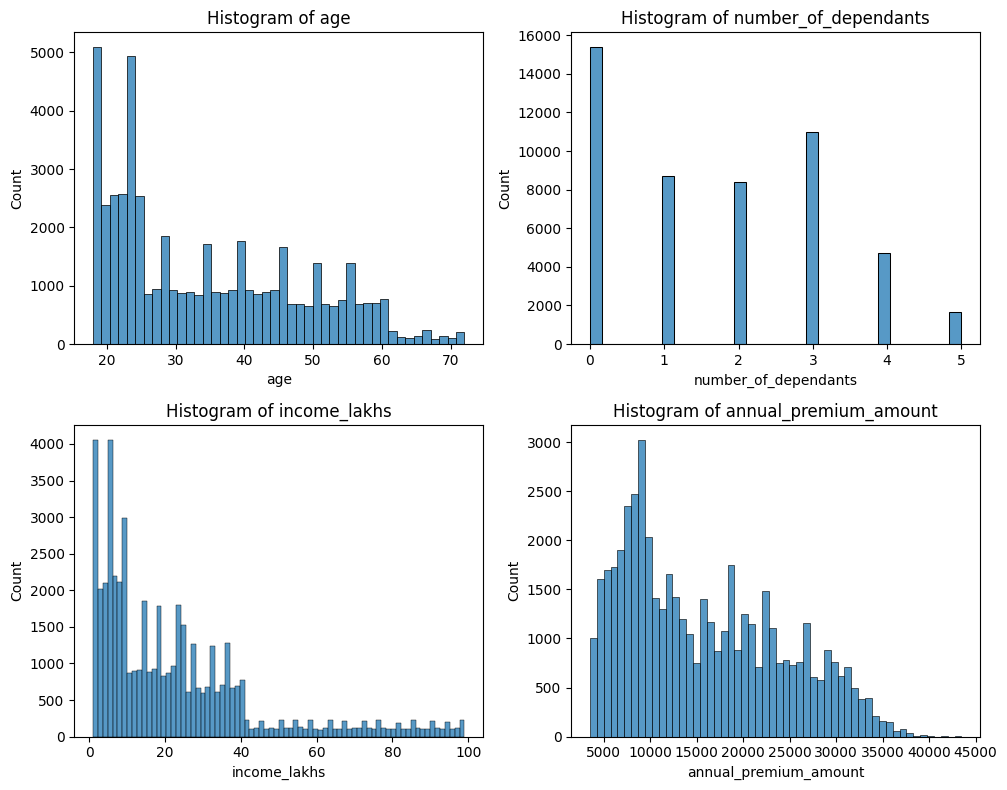

In [65]:
# Select numeric columns
numeric_columns = df2.select_dtypes(["float64", "int64"]).columns

# Create subplots with a fixed number of columns
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(10, 8))

# Plot histograms in each subplot
for i, numeric_column in enumerate(numeric_columns):
    ax=axes[i//2,i%2]
    sns.histplot(x=df2[numeric_column], ax=ax)
    ax.set_title(f'Histogram of {numeric_column}')

# Adjust layout
plt.tight_layout()
plt.show()

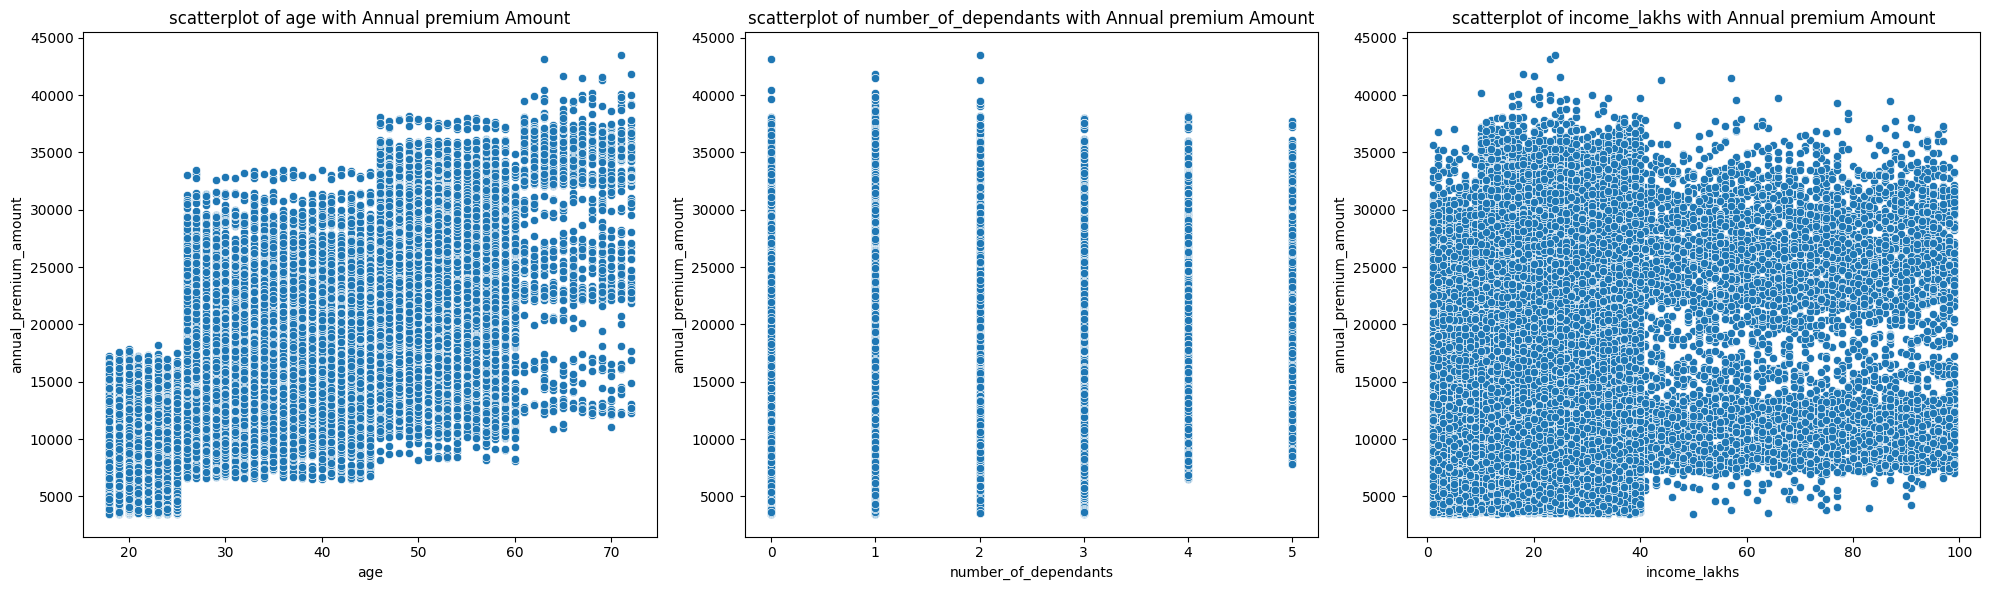

In [66]:
# Select numeric columns
numeric_columns = ['age','number_of_dependants','income_lakhs']

# Create subplots with a fixed number of columns
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(20, 6))

# Plot histograms in each subplot
for i, numeric_column in enumerate(numeric_columns):
    ax=axes[i]
    sns.scatterplot(df2,x=numeric_column, y='annual_premium_amount', ax=ax)
    ax.set_title(f'scatterplot of {numeric_column} with Annual premium Amount')

# Adjust layout
plt.tight_layout()
plt.show()


#### lets deal catogerical columns

In [67]:
catogerical_cols=["gender",	"region","marital_status","bmi_category",	"smoking_status","employment_status","income_level","medical_history","insurance_plan"]
for col in catogerical_cols:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [68]:
#unform the values
df["smoking_status"].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

In [69]:
df["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [70]:
pct_count=df2['gender'].value_counts(normalize=True)
print(pct_count.values)
print(pct_count.index)

[0.5495302 0.4504698]
Index(['Male', 'Female'], dtype='object', name='gender')


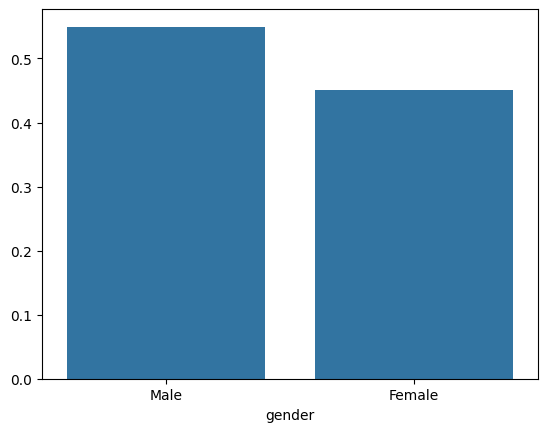

In [71]:
sns.barplot(x=pct_count.index,y=pct_count.values)
plt.show()

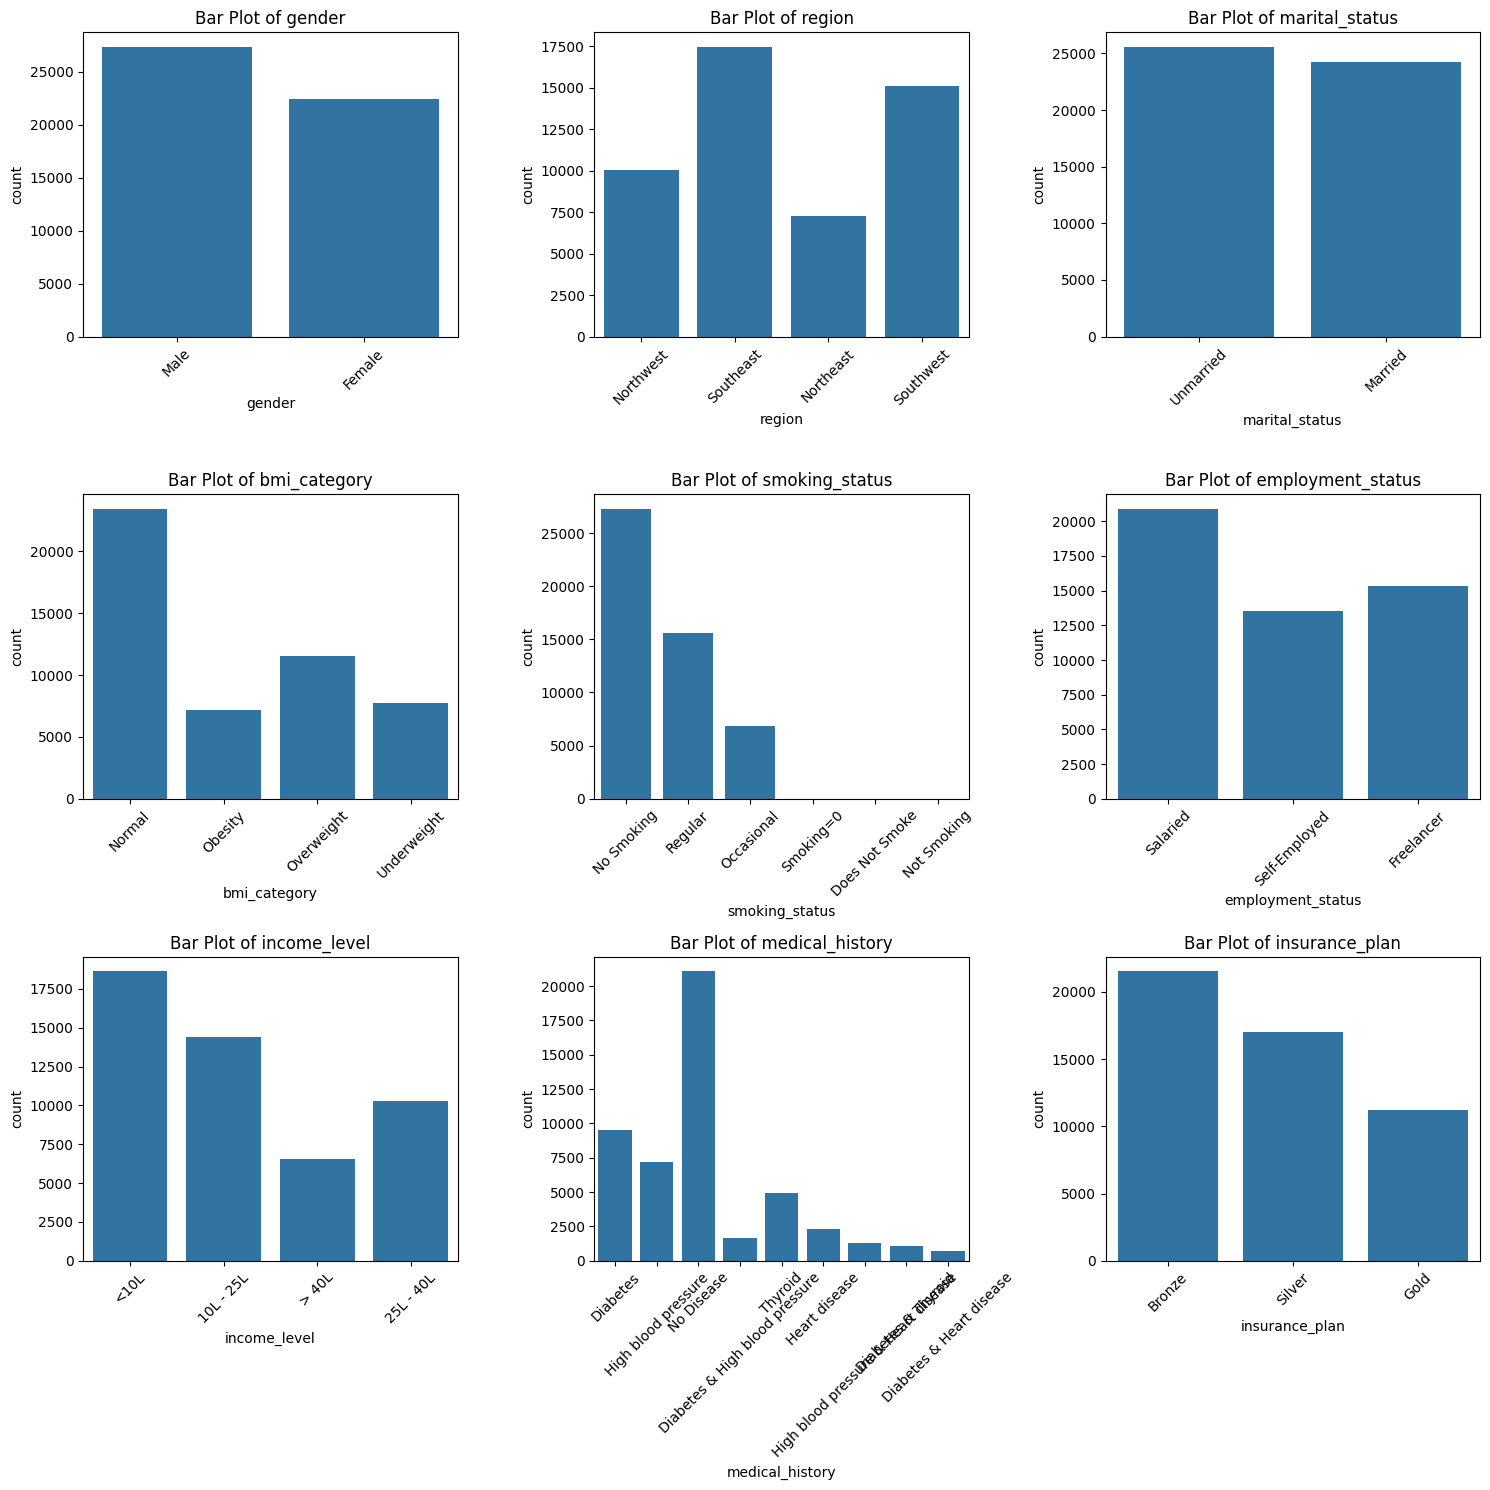

In [72]:
catogerical_cols=["gender",	"region","marital_status","bmi_category",	"smoking_status","employment_status","income_level","medical_history","insurance_plan"]
n_cols = 3
n_rows = (len(catogerical_cols) + n_cols - 1) // n_cols  # Calculate number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot bar plots for each categorical column
for i, col in enumerate(catogerical_cols):
    sns.countplot(x=df2[col], ax=axes[i])
    axes[i].set_title(f'Bar Plot of {col}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide any empty subplots if there are any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5314  3886    5189
25L - 40L         3686  2844    3753
<10L             12239   931    5495
> 40L              330  3662    2647


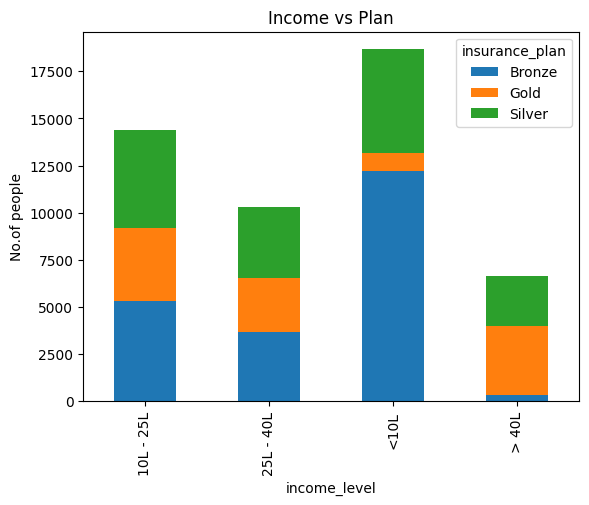

In [73]:
cross_tab=pd.crosstab(df["income_level"],df["insurance_plan"])
print(cross_tab)
cross_tab.plot(kind="bar",stacked=True)
plt.title("Income vs Plan")
plt.ylabel("No.of people")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

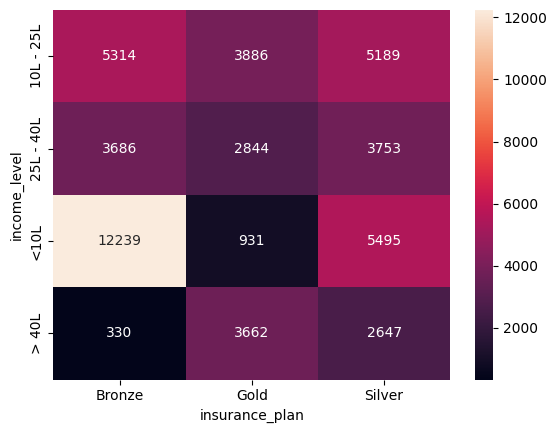

In [74]:
sns.heatmap(cross_tab, annot=True,fmt="d")


In [75]:
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303


In [76]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [77]:
risk_scores_from_client = {
    'no disease': 0,
    'diabetes': 6,
    'high blood pressure': 6,
    'thyroid': 5,
    'heart disease': 8,
    "none":0
}

#we have to use these data given by the client and convert the colums to score based on the desises they havee 
#if they have both , the summ  of the both iseeases will be his risk score


In [78]:
df2["medical_history"].str.split("&",expand=True).apply(lambda x: x.str.lower()).sample(5)

,0,1
8152,diabetes,None
36429,no disease,None
10069,thyroid,None
25809,diabetes,None
13132,no disease,None


you can see it saperated those diseases into individual columns

In [79]:
#store back those values into the data frame 
df2[["disease1","disease2"]]=df2["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.drop("medical_history",axis=1,inplace=True)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,Silver,13365,high blood pressure,None


In [80]:
df2["disease1"].fillna("none",inplace=True)
df2["disease2"].fillna("none",inplace=True)
df2["total_risk_score"]=0

In [81]:
for disease in ["disease1","disease2"]:
    df2["total_risk_score"]+=df2[disease].map(risk_scores_from_client)

max_score=df2["total_risk_score"].max()
min_score=df2["total_risk_score"].min()
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,none,6


In [82]:
df2["normalized_risk_score"]=(df2["total_risk_score"]-min_score)/(max_score-min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,none,6,0.428571


In [83]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [84]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [86]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [87]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3,'> 40L':4})
df2.income_level.unique()

array([1, 2, 4, 3])

In [98]:
df2["smoking_status"].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

In [99]:
#remaining are nomnal columns , so we have to use one hot encoding
nominal_cloumns=['gender', 'region', 'marital_status','bmi_category', 'smoking_status', 'employment_status']
df3=pd.get_dummies(df2,columns=nominal_cloumns,drop_first=True,dtype=int)

In [100]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49808 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49808 non-null  int64  
 1   number_of_dependants             49808 non-null  int64  
 2   income_level                     49808 non-null  int64  
 3   income_lakhs                     49808 non-null  int64  
 4   insurance_plan                   49808 non-null  int64  
 5   annual_premium_amount            49808 non-null  int64  
 6   disease1                         49808 non-null  object 
 7   disease2                         49808 non-null  object 
 8   total_risk_score                 49808 non-null  int64  
 9   normalized_risk_score            49808 non-null  float64
 10  gender_Male                      49808 non-null  int64  
 11  region_Northwest                 49808 non-null  int64  
 12  region_Southeast       

In [102]:
df4=df3.drop(["disease1","disease2","total_risk_score"],axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49808 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49808 non-null  int64  
 1   number_of_dependants             49808 non-null  int64  
 2   income_level                     49808 non-null  int64  
 3   income_lakhs                     49808 non-null  int64  
 4   insurance_plan                   49808 non-null  int64  
 5   annual_premium_amount            49808 non-null  int64  
 6   normalized_risk_score            49808 non-null  float64
 7   gender_Male                      49808 non-null  int64  
 8   region_Northwest                 49808 non-null  int64  
 9   region_Southeast                 49808 non-null  int64  
 10  region_Southwest                 49808 non-null  int64  
 11  marital_status_Unmarried         49808 non-null  int64  
 12  bmi_category_Obesity   

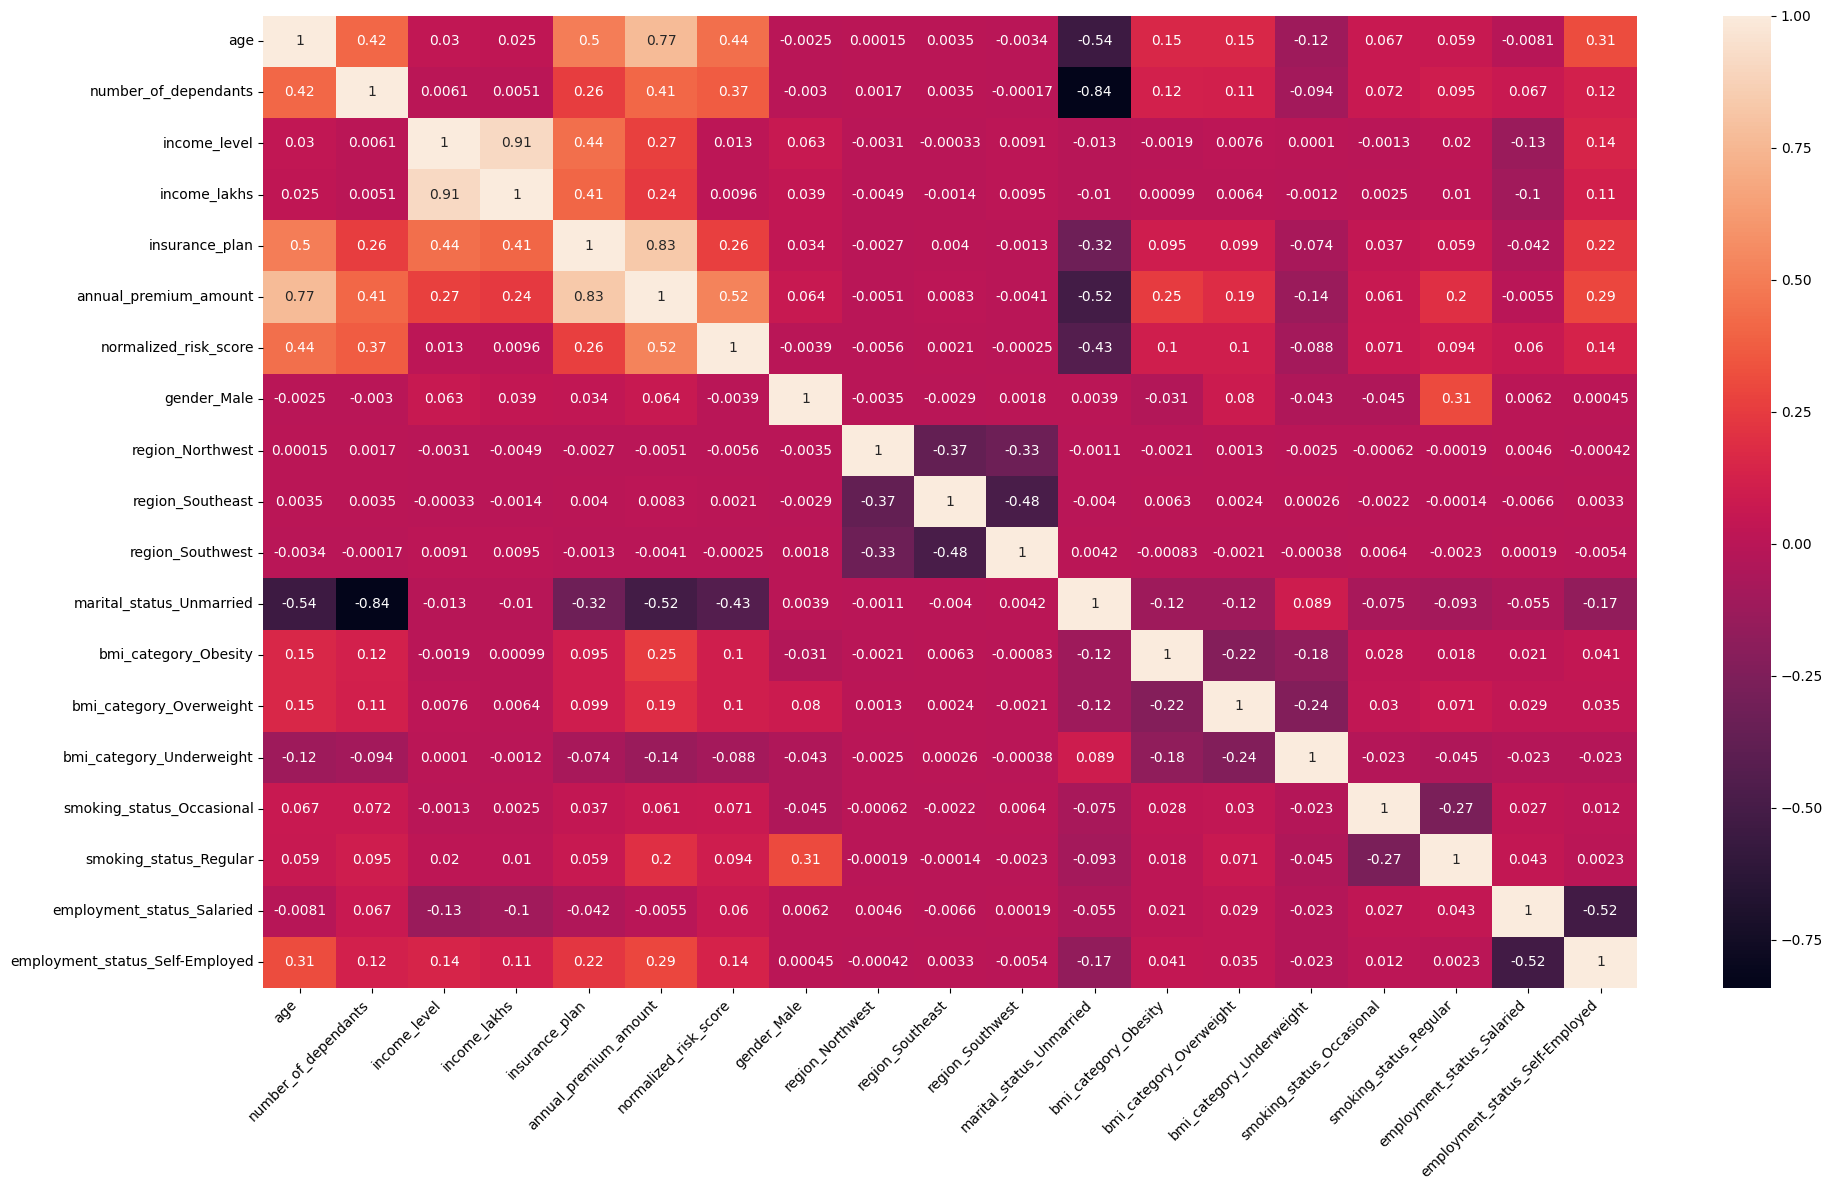

In [104]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [105]:
X=df4.drop("annual_premium_amount",axis=1)
y=df4.annual_premium_amount

In [112]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
cols_to_scale=["age","income_lakhs","income_level","number_of_dependants","insurance_plan"]
X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.051020,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.051020,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.193878,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


In [113]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000
mean,0.303691,0.343443,0.364627,0.221787,0.396623,0.291816,0.549530,0.200972,0.350365,0.302963,0.513693,0.143250,0.231148,0.155276,0.138291,0.313765,0.419471,0.272004
std,0.253393,0.298411,0.348905,0.223692,0.392273,0.287456,0.497546,0.400731,0.477089,0.459544,0.499817,0.350331,0.421571,0.362171,0.345209,0.464027,0.493477,0.444997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.153061,0.500000,0.357143,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.306122,0.500000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df["Column"]=data.columns
    vif_df["VIF"]=[variance_inflation_factor(data.values,i)for i in range(data.shape[1])]
    return vif_df
calculate_vif(X)

,Column,VIF
0,age,4.568203
1,number_of_dependants,4.533619
2,income_level,12.609918
3,income_lakhs,11.390919
4,insurance_plan,3.574805
5,normalized_risk_score,2.686553
6,gender_Male,2.420908
7,region_Northwest,2.101878
8,region_Southeast,2.921178
9,region_Southwest,2.669438


as income level and income lakhs have high and close vif , it means they are highly corelated , so lets drop the highest one income_level and check how the vif score wil look

In [120]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,4.546399
1,number_of_dependants,4.526213
2,income_lakhs,2.487302
3,insurance_plan,3.438176
4,normalized_risk_score,2.686293
5,gender_Male,2.409383
6,region_Northwest,2.100181
7,region_Southeast,2.918617
8,region_Southwest,2.667140
9,marital_status_Unmarried,3.396399


now you can see all are in same range , so we shoud drop the income level from our data.

In [122]:
X_reduced=X.drop("income_level",axis="columns")
X_reduced.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.051020,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.051020,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.193878,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.775510,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,1.000000,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Model training and fine tuning

In [124]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3, random_state=10)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_train: ",y_train.shape)

X_train:  (34865, 17)
X_test:  (14943, 17)
y_train:  (34865,)
y_train:  (34865,)


In [129]:
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
train_score=model_lr.score(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
print("Train score: ",train_score)
print("Test score: ",test_score)

Train score:  0.9282872866388545
Test score:  0.9277068802881224


In [155]:
from sklearn.metrics import mean_squared_error
y_pred_lr=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred_lr)
rmse_lr=np.sqrt(mse_lr)
print("Linearregressor : MSE:'",mse_lr,"'  RMSE:'",rmse_lr,"'")

Linearregressor : MSE:' 5134563.441258953 '  RMSE:' 2265.9575109120983 '


In [156]:
print(model_lr.coef_)
print(model_lr.intercept_)
feature_importances=model_lr.coef_

[11320.84480976  -598.60654635  -387.23104353 12445.21223389
  4830.35511008   141.16467047   -19.93312597    72.90102336
    18.96701435  -880.43219853  3363.77237148  1616.18488467
   359.97028802   679.17891348  2239.27098107   165.26365654
   414.73816833]
4721.2842279234865


In [133]:
coeff_df=pd.DataFrame(feature_importances,columns=["coefficients"],index=X_test.columns)
coeff_df


,coefficients
age,11320.844810
number_of_dependants,-598.606546
income_lakhs,-387.231044
insurance_plan,12445.212234
normalized_risk_score,4830.355110
gender_Male,141.164670
region_Northwest,-19.933126
region_Southeast,72.901023
region_Southwest,18.967014
marital_status_Unmarried,-880.432199


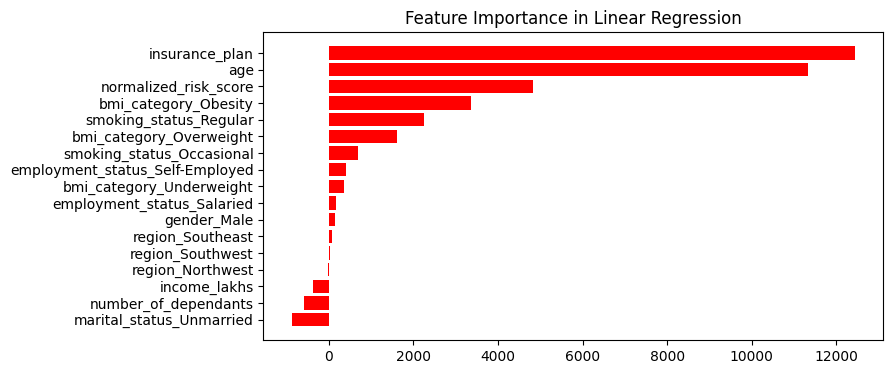

In [140]:
coeff_df_sorted = coeff_df.sort_values(by="coefficients")

# Plot the sorted horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(coeff_df_sorted.index, coeff_df_sorted["coefficients"], color="red")
plt.title("Feature Importance in Linear Regression")
plt.show()

In [147]:
from sklearn.linear_model import Ridge

model_ridge=Ridge(alpha=10)
model_ridge.fit(X_train,y_train)
train_score_ridge=model_ridge.score(X_train,y_train)
test_score_ridge=model_ridge.score(X_test,y_test)
print("Train score: ",train_score_ridge)
print("Test score: ",test_score_ridge)

Train score:  0.9282834937606873
Test score:  0.9277055168457802


In [153]:
from xgboost import XGBRegressor
model_xg=XGBRegressor(n_estimators=10,max_depth=10)
model_xg.fit(X_train,y_train)
train_score_xg=model_xg.score(X_train,y_train)
test_score_xg=model_xg.score(X_test,y_test)
print("Train score: ",train_score_xg)
print("Test score: ",test_score_xg)

Train score:  0.9845805168151855
Test score:  0.980279803276062


In [154]:
from sklearn.metrics import mean_squared_error
y_pred_xg=model_xg.predict(X_test)
mse_xg=mean_squared_error(y_test,y_pred_xg)
rmse_xg=np.sqrt(mse_xg)
print("XGboost regressor : MSE:'",mse_xg,"'  RMSE:'",rmse_xg,"'")

XGboost regressor : MSE:' 1400611.3329192067 '  RMSE:' 1183.474263733355 '


In [163]:
param_dist = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01,0.1, 0.2],
    'max_depth': [3, 4,5]
}
model_xgb=XGBRegressor()
# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    scoring='r2',
    cv=3  # 3-fold cross-validation
)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.2}
Best score:  0.9817339579264323


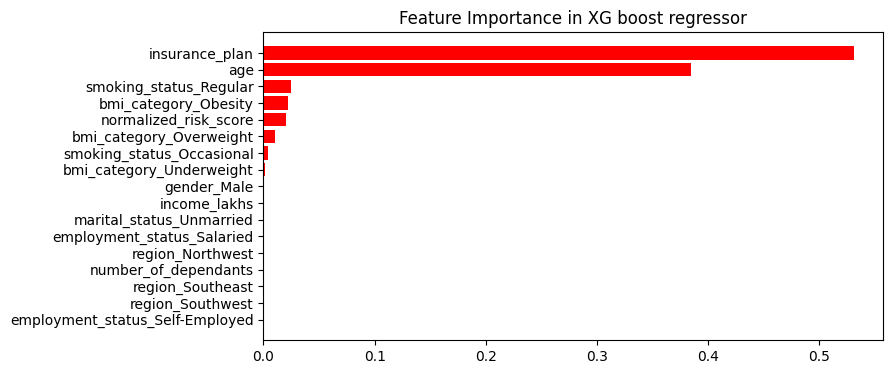

In [169]:
best_model=random_search.best_estimator_
feature_importances=best_model.feature_importances_
coeff_df=pd.DataFrame(feature_importances,columns=["coefficients"],index=X_test.columns)
coeff_df_sorted = coeff_df.sort_values(by="coefficients")

# Plot the sorted horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(coeff_df_sorted.index, coeff_df_sorted["coefficients"], color="red")
plt.title("Feature Importance in XG boost regressor")
plt.show()

##### Feature imoprtance in XGboost may not be straightforward to interpret as feature impoprtance in Linear regression, since XGboost is a tree based model

### Error Analysis

In [173]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=residuals*100/y_test 
results_df=pd.DataFrame({
    "actual":y_test,
     "predicted":y_pred,
     "diff":residuals,
     "diff_pct":residuals_pct,
})
results_df.head()

,actual,predicted,diff,diff_pct
34025,6539,6459.968750,-79.031250,-1.208614
29504,11853,14423.279297,2570.279297,21.684631
12892,31155,30883.888672,-271.111328,-0.870202
34662,4395,6658.313477,2263.313477,51.497462
25334,19986,19517.423828,-468.576172,-2.344522


<Axes: xlabel='diff_pct', ylabel='Count'>

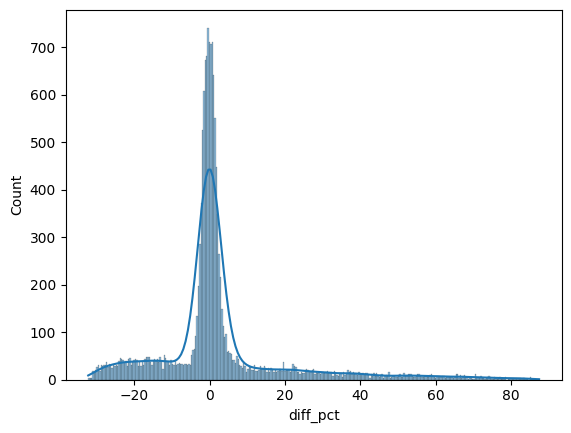

In [175]:
sns.histplot(results_df["diff_pct"],kde=True)

you can see that most of the errors are less than 10% , but model also prediction 80% difference for some casess , this is something thw business owners don't want , so lets try to decrease it

In [178]:
#lets asssume our business owner givn a limit of  10%, lets see how many lies more than 10%
extreme_error_threshold=10
results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].count()

actual       4361
predicted    4361
diff         4361
diff_pct     4361
dtype: int64

In [179]:
extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

In [182]:
#calculate the percentage of errers more than 10%
extreme_error_pct= extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.18423342033059

##### nearly 30 percent of my errors are extreme errors !!

In [188]:
#lets check how many records have more than 50%error
extreme_error_threshold=50
print("No. of erros more than 50%: ",results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].actual.count())
results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].sort_values(by="diff_pct",ascending=False)

No. of erros more than 50%:  545


,actual,predicted,diff,diff_pct
624,3505,6569.076660,3064.076660,87.420161
10288,3517,6556.057617,3039.057617,86.410509
23975,3520,6555.829590,3035.829590,86.245159
25701,3615,6710.032715,3095.032715,85.616396
1692,3522,6530.321289,3008.321289,85.415142
...,...,...,...,...
14328,4664,7001.173828,2337.173828,50.110931
9318,4941,7416.948730,2475.948730,50.110276
15002,4680,7022.755859,2342.755859,50.058886
30523,4454,6683.562012,2229.562012,50.057522


##### so we have a sevier problem we cannot deploy this model !!,  
##### lets analyse data and find out what may be the reason for the errors 

In [191]:
#lets see the X_test data for which the exreme error is more
#so acces X_test values theough the index in the extreme_results_df
extreme_errors_df=X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
29504,0.092593,0.6,0.040816,1.0,0.428571,0,0,0,1,0,0,0,0,0,0,1,0
34662,0.000000,0.6,0.102041,0.0,0.000000,1,0,0,1,0,0,0,1,0,0,0,0
7446,0.037037,0.0,0.336735,0.0,0.000000,1,1,0,0,1,0,0,1,0,1,0,0
33557,0.129630,0.0,0.367347,0.0,0.000000,1,0,0,1,1,0,0,1,1,0,0,0
15549,0.092593,0.0,0.632653,0.5,0.000000,1,0,0,1,1,0,0,0,0,1,0,1


<Axes: xlabel='income_lakhs', ylabel='Count'>

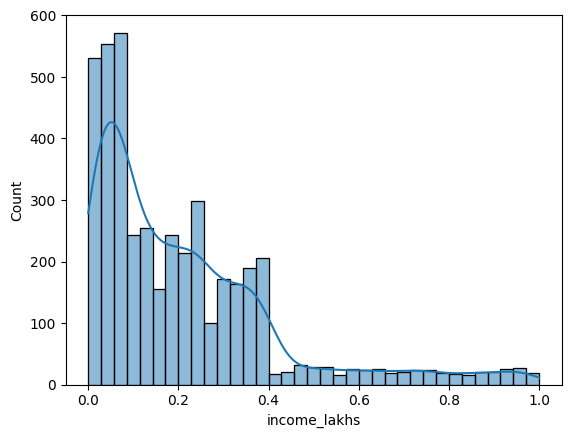

In [192]:
#lets tale one feature and try to plot distribution
sns.histplot(extreme_errors_df.income_lakhs,kde=True)

##### we wont get clear idea by watching the only errors disctibution because , the original distribution my be also same , so lets plot the error one and original one side by side so that we can compare both of theem 

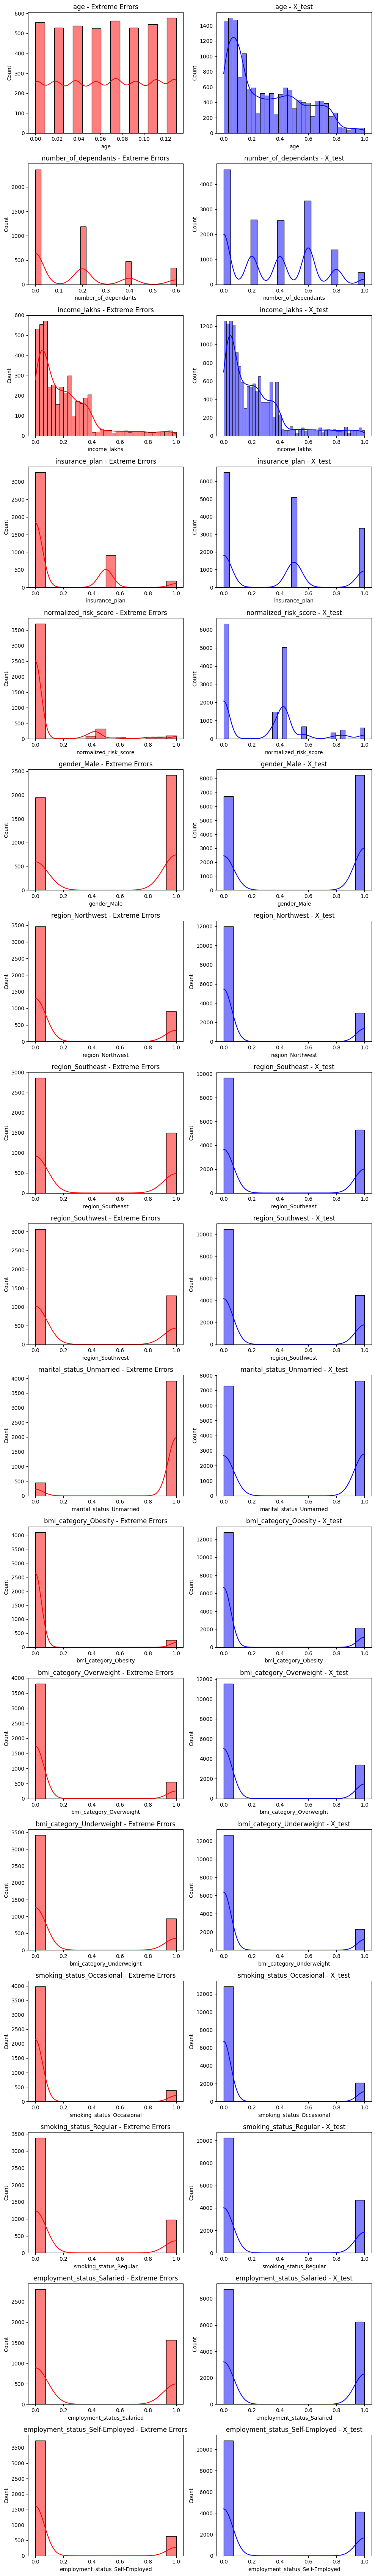

In [193]:
columns = extreme_errors_df.columns  # Get the common column names

# Number of columns
num_cols = len(columns)

# Create subplots: 2 columns (side by side), and number of rows = number of columns
fig, axes = plt.subplots(num_cols, 2, figsize=(10, 4 * num_cols))

# Loop through each column and create histograms
for i, col in enumerate(columns):
    # Plot for extreme_errors_df
    sns.histplot(extreme_errors_df[col], ax=axes[i, 0], color="red", kde=True)
    axes[i, 0].set_title(f"{col} - Extreme Errors")
    
    # Plot for X_test
    sns.histplot(X_test[col], ax=axes[i, 1], color="blue", kde=True)
    axes[i, 1].set_title(f"{col} - X_test")

# Adjust layout for better readability
plt.tight_layout()
plt.show()

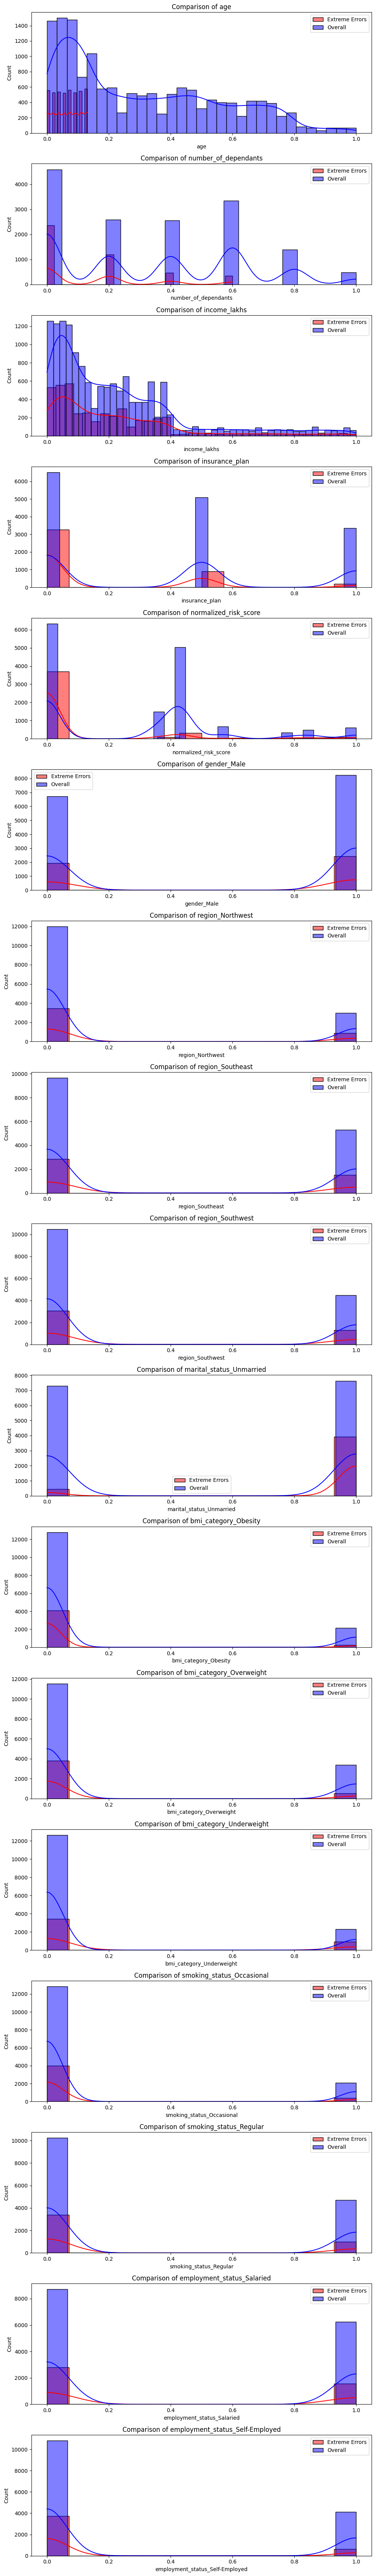

In [197]:
num_cols = len(columns)

# Create subplots: one row per column
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4 * num_cols))

# Loop through each column and create histograms
for i, col in enumerate(columns):
    # Plot histograms for extreme_errors_df and X_test on the same axis
    sns.histplot(extreme_errors_df[col], ax=axes[i], color="red", kde=True, label='Extreme Errors')
    sns.histplot(X_test[col], ax=axes[i], color="blue", kde=True, label='Overall')

    # Set titles and labels
    axes[i].set_title(f"Comparison of {col}")
    axes[i].legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()

you can see that all the columns have almost same distribution, you can see some difference because of no.of rows in both of them ,
#### but you can see "age" column has different distribution when compared to its X_test, so we got a insight that age is the one we have to focus and error is more based on the age

In [208]:
#so lets scale them all the  column back to check the actual age group we getting erors
cols_to_unscale=['age','income_lakhs','number_of_dependants','insurance_plan']
df_reversed=pd.DataFrame()
df_reversed[cols_to_unscale]=df4.loc[extreme_results_df.index][cols_to_unscale]

In [209]:
df_reversed.head()

,age,income_lakhs,number_of_dependants,insurance_plan
29504,23,5,3,3
34662,18,11,3,1
7446,20,34,0,1
33557,25,37,0,1
15549,23,63,0,2


<Axes: xlabel='age', ylabel='Count'>

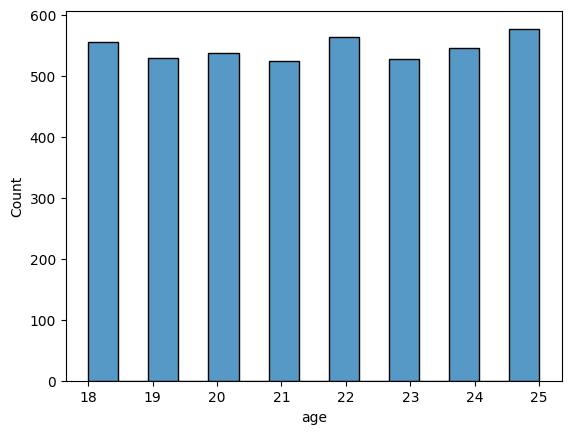

In [211]:
sns.histplot(df_reversed["age"])

#### clearly you can understand we have problem with age group 18-25

In [212]:
df_reversed.describe()

,age,income_lakhs,number_of_dependants,insurance_plan
count,4361.000000,4361.000000,4361.000000,4361.000000
mean,21.527631,21.552855,0.724146,1.292823
std,2.309976,20.468706,0.942029,0.541207
min,18.000000,1.000000,0.000000,1.000000
25%,20.000000,7.000000,0.000000,1.000000
50%,22.000000,16.000000,0.000000,1.000000
75%,24.000000,30.000000,1.000000,1.000000
max,25.000000,99.000000,3.000000,3.000000


#### clearly you can understand we have problem with age group 18-25

### So we have to do model segmentation to tacle this problem 
In real-world machine learning applications, there is no one-size-fits-all solution for most use cases. To address different scenarios, we may employ various models. This practice is known as model segmentation.